In [2]:
!pip install --quiet openai requests pandas matplotlib

# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json, os
from openai import OpenAI
import matplotlib.font_manager as fm
from dotenv import load_dotenv

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

load_dotenv()

# OpenAI API 클라이언트 생성
API_KEY = os.getenv("API_KEY")

# OpenAI API 클라이언트 생성
client = OpenAI(api_key=API_KEY)  # <- 본인 API 키 입력


In [4]:
# =========================================
# 1) 사용자 입력 (자연어로)
# =========================================
user_query = "서울의 지난 7일간 일별 날씨(평균기온, 강수량, 풍속)를 알려줘"


In [5]:
# =========================================
# 2) GPT에게 자연어
# =========================================
tools = [{
    "type": "function",
    "function": {
        "name": "extract_weather_params",
        "description": "날씨 요청에서 위치, 기간, 필요한 지표 추출",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {"type": "string"},
                "days": {"type": "integer"},
                "metrics": {"type": "array", "items": {"type": "string"}}
            },
            "required": ["location","days","metrics"]
        }
    }
}]

In [6]:
resp = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role":"system","content":"너는 날씨 요청 파라미터를 뽑는 어시스턴트다."},
        {"role":"user","content":user_query}
    ],
    tools=tools,
    tool_choice="auto"
)


In [7]:
call = resp.choices[0].message.tool_calls[0]
args = json.loads(call.function.arguments)
print(" 추출된 파라미터:", args)


 추출된 파라미터: {'location': '서울', 'days': 7, 'metrics': ['평균기온', '강수량', '풍속']}


In [8]:
# =========================================
# 3) Open-Meteo API 호출
# =========================================
# 서울 위도/경도 (예시)
coords = {"lat":37.5665,"lon":126.9780}
days = args.get("days", 7)

url = (
    f"https://api.open-meteo.com/v1/forecast?"
    f"latitude={coords['lat']}&longitude={coords['lon']}"
    f"&past_days={days}&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max"
    f"&timezone=Asia%2FSeoul"
)

res = requests.get(url)
data = res.json()
print(" 날씨 데이터 수신 완료")

 날씨 데이터 수신 완료


In [9]:
# =========================================
# 4) DataFrame 변환
# =========================================
daily = data["daily"]
df = pd.DataFrame(daily)
df.rename(columns={
    "time":"날짜",
    "temperature_2m_max":"최고기온",
    "temperature_2m_min":"최저기온",
    "precipitation_sum":"강수량",
    "windspeed_10m_max":"최대풍속"
}, inplace=True)

print(" DataFrame 미리보기:")
print(df)


 DataFrame 미리보기:
            날짜  최고기온  최저기온   강수량  최대풍속
0   2025-08-15  30.0  23.4   1.3   5.1
1   2025-08-16  31.1  23.5   0.0   7.3
2   2025-08-17  30.1  22.8   0.0   6.0
3   2025-08-18  30.0  24.0   0.2   7.0
4   2025-08-19  29.9  24.5   1.0   7.2
5   2025-08-20  31.0  23.6   0.4   6.0
6   2025-08-21  31.6  23.2   0.2   5.4
7   2025-08-22  31.2  23.5   0.0   6.6
8   2025-08-23  31.6  24.0   0.0   6.0
9   2025-08-24  33.6  24.8   0.0   6.5
10  2025-08-25  32.0  24.9  16.9  14.7
11  2025-08-26  29.7  25.4  17.4  13.4
12  2025-08-27  30.8  23.7   0.0  11.2
13  2025-08-28  29.4  24.6   0.0  16.0


/tmp/ipython-input-514794591.py:13: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-514794591.py:13: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-514794591.py:13: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-514794591.py:13: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-514794591.py:13: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-514794591.py:13: UserWarning: Glyph 44540 (\N{HANGUL SYLLABLE GEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-514794591.py:13: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ip

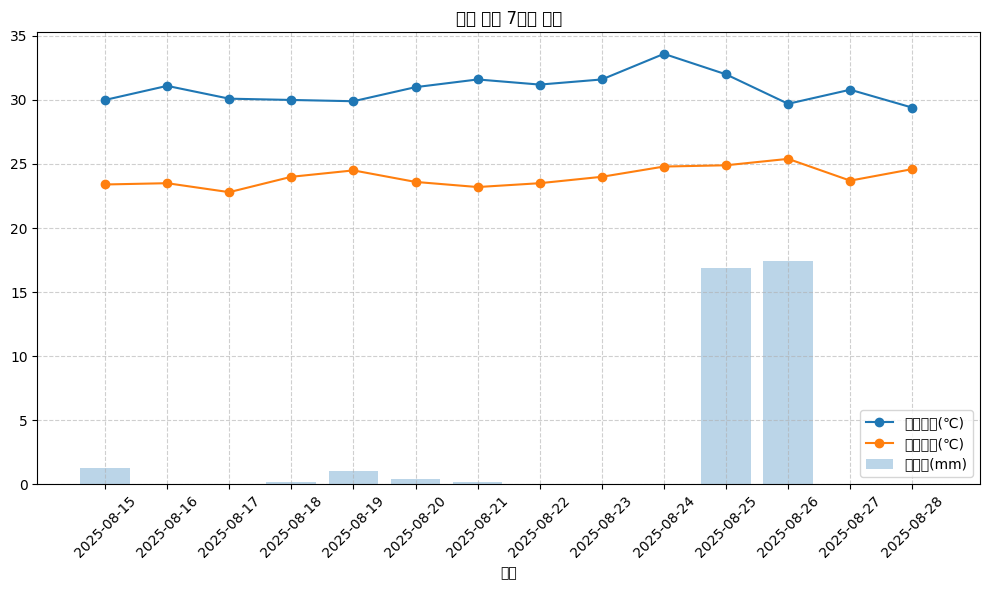

In [10]:
# =========================================
# 5) 그래프 시각화
# =========================================
plt.figure(figsize=(10,6))
plt.plot(df["날짜"], df["최고기온"], marker="o", label="최고기온(℃)")
plt.plot(df["날짜"], df["최저기온"], marker="o", label="최저기온(℃)")
plt.bar(df["날짜"], df["강수량"], alpha=0.3, label="강수량(mm)")
plt.xticks(rotation=45)
plt.title("서울 최근 7일간 날씨")
plt.xlabel("날짜")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [11]:
# gpt 프롬프팅 >> system > " 날씨전문가 " "df 에 있는 날씨 정보로만 답해라 " "간결하고 친근한 답변"
# DF 에서 데이터 찾아서 .. 답변 >> json

### " 코드 내용 "" .. system 에 " 날씨전문가 " "df 에 있는 날씨 정보로만 답해라 " "간결하고 친근한 답변"

In [13]:
# =========================================
# 6) GPT 요약 & 질의응답 (데이터 기반)
# =========================================
try:
    # 숫자형 보정
    for col in ["최고기온", "최저기온", "강수량", "최대풍속"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 요약 통계
    period = f"{df['날짜'].min()} ~ {df['날짜'].max()}"
    stats = {
        "기간": period,
        "평균_최고기온_℃": round(df["최고기온"].mean(), 1) if "최고기온" in df else None,
        "평균_최저기온_℃": round(df["최저기온"].mean(), 1) if "최저기온" in df else None,
        "총_강수량_mm": round(df["강수량"].sum(), 1) if "강수량" in df else None,
        "최대_풍속_mps": round(df["최대풍속"].max(), 1) if "최대풍속" in df else None,
    }

    # 핵심 일자(가장 더움/추움/비 많이 온 날 등)
    hi_row = df.loc[df["최고기온"].idxmax()] if "최고기온" in df and df["최고기온"].notna().any() else None
    lo_row = df.loc[df["최저기온"].idxmin()] if "최저기온" in df and df["최저기온"].notna().any() else None
    rain_row = df.loc[df["강수량"].idxmax()] if "강수량" in df and df["강수량"].notna().any() else None
    wind_row = df.loc[df["최대풍속"].idxmax()] if "최대풍속" in df and df["최대풍속"].notna().any() else None

    highlights = {
        "가장_더웠던_날": {"날짜": hi_row["날짜"], "최고기온_℃": hi_row["최고기온"]} if hi_row is not None else None,
        "가장_추웠던_날": {"날짜": lo_row["날짜"], "최저기온_℃": lo_row["최저기온"]} if lo_row is not None else None,
        "비가_가장_많이_왔던_날": {"날짜": rain_row["날짜"], "강수량_mm": rain_row["강수량"]} if rain_row is not None else None,
        "풍속이_가장_강했던_날": {"날짜": wind_row["날짜"], "최대풍속_mps": wind_row["최대풍속"]} if wind_row is not None else None,
    }

    # 사용자 질문 입력
    qa_question = input("\n 날씨 데이터에 대해 질문을 입력하세요 (예: '가장 더웠던 날은? 총 강수량은?')\n> ").strip()

    # 컨텍스트(JSON) 구성 - 7일치라 용량이 작아 그대로 전달
    context = {
        "요약통계": stats,
        "핵심하이라이트": highlights,
        "일별데이터": df.to_dict(orient="records")
    }
    context_json = json.dumps(context, ensure_ascii=False)

    # GPT 프롬프트: 데이터 외 추측 금지 + 단위 표기
    qa_resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role":"system",
                "content": (
                    "너는 기상 데이터 분석가다. 반드시 주어진 JSON 데이터만 근거로 답하라. "
                    "추측하거나 외부 정보를 추가하지 말라. 수치는 단위를 함께 제시하라. "
                    "가능하면 2~4문장으로 간결히 답하고"
                )
            },
            {
                "role":"user",
                "content": f"데이터(JSON): {context_json}\n\n질문: {qa_question}"
            }
        ],
        temperature=0.2,
        seed=7
    )

    print("\n GPT 응답:\n", qa_resp.choices[0].message.content)

except Exception as e:
    print(" GPT 질의응답 처리 중 오류:", e)



 날씨 데이터에 대해 질문을 입력하세요 (예: '가장 더웠던 날은? 총 강수량은?')
> 가장 더운 날은?

 GPT 응답:
 가장 더웠던 날은 2025년 8월 24일로, 최고기온은 33.6℃입니다.
